This a part of coursera [course](https://www.coursera.org/learn/introduction-to-machine-learning-in-production) 

In [1]:
from IPython.display import Image, display

In [2]:
from pathlib import Path

In [3]:
Path.ls = lambda x:sorted(list(x.iterdir()))

- We have some images in our images folder. Lets see some of images. But ony jpg images are relevant to this folder.
- I have created a function previously so that if we write path.ls() we will see all the files inside those path.
- Following line I am creating list comprehension and searching only jpg files from all files

> I need to go one folder upper, that's why used ``pathlib.parent`` 

In [33]:
im_path = Path(Path.cwd().parent/'images')

In [34]:
all_images =[ i for i in  im_path.ls() if '.jpg' in i.as_posix()]

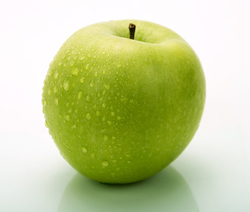

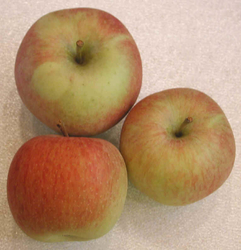

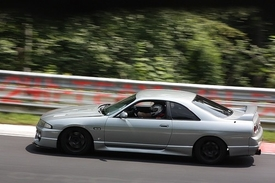

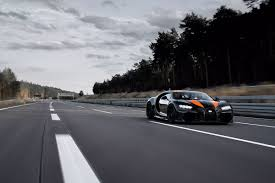

In [35]:
[display(Image(i)) for i in all_images[:4]];

> for object detection ``cvlib`` is a very handy library. Let's see how it works

In [23]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

In [19]:
all_images[0]

WindowsPath('C:/Users/hasan/Documents/GitHub/HasanGoni.github.io/images/apple.jpg')

In [22]:
img = cv2.imread(f'{all_images[0]}')

In [25]:
bbox, label, conf = cv.detect_common_objects(img, confidence=0.5, model='yolov3-tiny')

In [27]:
label, conf

(['apple'], [0.6279281973838806])

In [29]:
img_with_bbox  = draw_bbox(img, bbox, label, conf)

In [37]:
output_path = Path(im_path/'image_with_bbox')
output_path.mkdir(exist_ok=True, parents=True)

In [ ]:
images_with_bboxes = all_iam

In [40]:
cv2.imwrite(f'{output_path}/{label}.jpg', img_with_bbox);

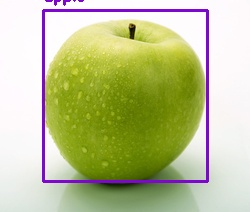

In [41]:
display(Image(f'{output_path}/{label}.jpg'))

- Everything is done manually. Now we will write a function.
- The function will take a file name
- create image from file name using ``opencv``.
- detect objects in that image
- based on confidence level it will detect different objects
- then save the detected image in output folder

In [51]:
def detect_draw_box(filename, 
                    model='yolov3-tiny',
                    confidence=0.5,
                    output_path=output_path):
    """
    Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str) or pathlib object: Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    # Reading images from filename, output will be a numpy array
    img = cv2.imread(f'{filename}')
    
    # Perform object detection
    bbox, label, conf = cv.detect_common_objects(img,
                             confidence=confidence,
                             model=model)
    print(f'........\n Image {filename.stem}\n')
    
    for lab, con in zip(label, conf):
        print(f' Detected object {lab} ,with confidence {con:.2f}\n')
        
    # Create a new image that includes the bounding boxes
    output_img = draw_bbox(img, 
                           bbox, 
                           label, 
                           conf)
    cv2.imwrite(f'{output_path}/{filename.name}',output_img)
    display(Image(f'{output_path}/{filename.name}'))
    

........
 Image apple

 Detected object apple ,with confidence 0.63



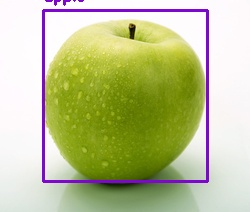

In [53]:
detect_draw_box(all_images[0])

........
 Image apple

 Detected object apple ,with confidence 0.63



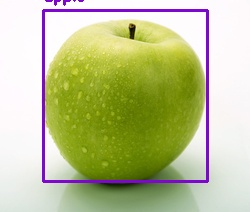

........
 Image apples

 Detected object apple ,with confidence 0.98

 Detected object apple ,with confidence 0.95

 Detected object apple ,with confidence 0.83



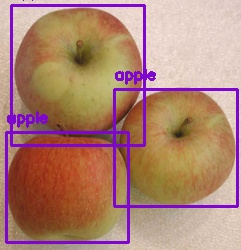

........
 Image car

 Detected object car ,with confidence 0.97



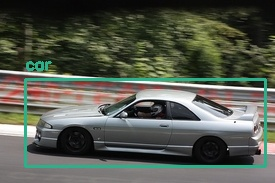

........
 Image car1

 Detected object car ,with confidence 0.99



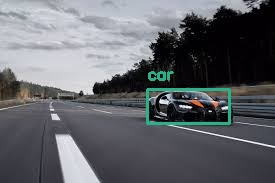

In [56]:
[detect_draw_box(i) for i in all_images[:4]];

........
 Image fruits

 Detected object apple ,with confidence 0.93

 Detected object orange ,with confidence 0.87

 Detected object dining table ,with confidence 0.76

 Detected object orange ,with confidence 0.73

 Detected object apple ,with confidence 0.67

 Detected object orange ,with confidence 0.64

 Detected object apple ,with confidence 0.55



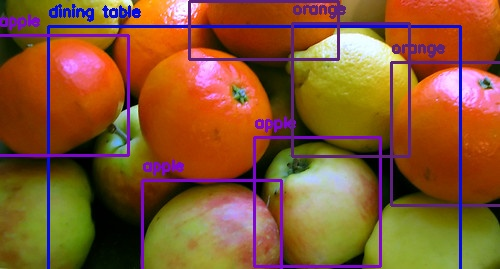

In [59]:
detect_draw_box(all_images[-2])

........
 Image fruits

 Detected object apple ,with confidence 0.93

 Detected object orange ,with confidence 0.87

 Detected object dining table ,with confidence 0.76

 Detected object orange ,with confidence 0.73

 Detected object apple ,with confidence 0.67

 Detected object orange ,with confidence 0.64

 Detected object apple ,with confidence 0.55

 Detected object apple ,with confidence 0.44

 Detected object orange ,with confidence 0.41

 Detected object apple ,with confidence 0.39

 Detected object apple ,with confidence 0.37

 Detected object apple ,with confidence 0.33



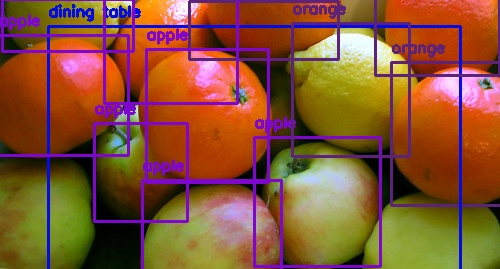

In [60]:
detect_draw_box(all_images[-2],
               confidence=0.2)

# Fastapi

In [61]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException

In [84]:
app = FastAPI(title='Deploying a ML Model with FastAPI')

class Model(str, Enum):
    yolov3tiny = 'yolov3-tiny'
    yolov3="yolov3"
    
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."

@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):
    # input validation
    # ..............................................................
    filename = file.filename
    fileExtension = filename.split('.')[-1] in ('jpg', 'jpeg', 'png')
    
    if not fileExtension:
        raise HTTPException(status_code=415,
                            detail='Unsupported file provided')
    
    
    # Transformation raw iamge into cv2 image
    # .............................................................
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the begining (postion zero)
    image_stream.seek(0)
    
    # Write the stream into numpy array
    
    file_bytes = np.asarray(bytearray(image_stream.read()),
                          dtype=np.uint8)
    
    # From numpy array to as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # Run object detection
    # ............................................................
    bbox, label, conf = cv.detect_common_objects(image,
                                                 model=model)
    
    # bounding box
    output_im = draw_bbox(image,
                          bbox,
                          label,
                          conf)
    # Save images in server
    cv2.imwrite(f'image_with_bbox/{filename}',
                output_im)
    
    # Stream the response to client
    # .........................................................
    
    # open the saved image for reading in binary mode
    file_image = open(f'image_with_bbox/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")
    
    


In [85]:

# Allows the server to be run in this interactive environment
nest_asyncio.apply()
host =  "127.0.0.1"

# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Spin up the server!      
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [10292]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [10292]


- Now application is runnning.
- one should visit the follwoing address
http://localhost:8000/docs
- Then select try it out
- Then choose a file for image detection.
- you should see the output

# Consuming your model from another client

It is awesome that fastAPI allows you to interact with your API through its built-in client. However, you might wonder how you can interact with your API using regular code and not some UI.

- It is also possible